In [3]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [4]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data / Train-Test split
See model training notebooks for more information

In [5]:
import os
os.chdir('/kyukon/data/gent/courses/2023/ahta_C003695/members/vsc46720')

In [6]:
BRAIN = sp.read_h5ad("./MouseData/mouse_brain.h5ad")
BRAIN

AnnData object with n_obs × n_vars = 6862 × 21808
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'peaks_snn_res.1.2', 'seurat_clusters', 'nCount_ACTIVITY', 'nFeature_ACTIVITY', 'predicted.id', 'prediction.score.Vip', 'prediction.score.Lamp5', 'prediction.score.Sst', 'prediction.score.Sncg', 'prediction.score.Serpinf1', 'prediction.score.Pvalb', 'prediction.score.Endo', 'prediction.score.Peri', 'prediction.score.L6.CT', 'prediction.score.L6b', 'prediction.score.L6.IT', 'pre

In [7]:
from sklearn.model_selection import train_test_split

# Filtering + Train/Test Split
cutoff = 0.001

cell_types, type_numbers = np.unique(BRAIN.obs['predicted.id'], return_counts=True)
bad_types = cell_types[type_numbers / len(BRAIN.obs['predicted.id'])<cutoff]

bad_types_mask = np.invert(np.isin(BRAIN.obs['predicted.id'], bad_types))
X = BRAIN.X[bad_types_mask]
Y = BRAIN.obs['predicted.id'][bad_types_mask]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)

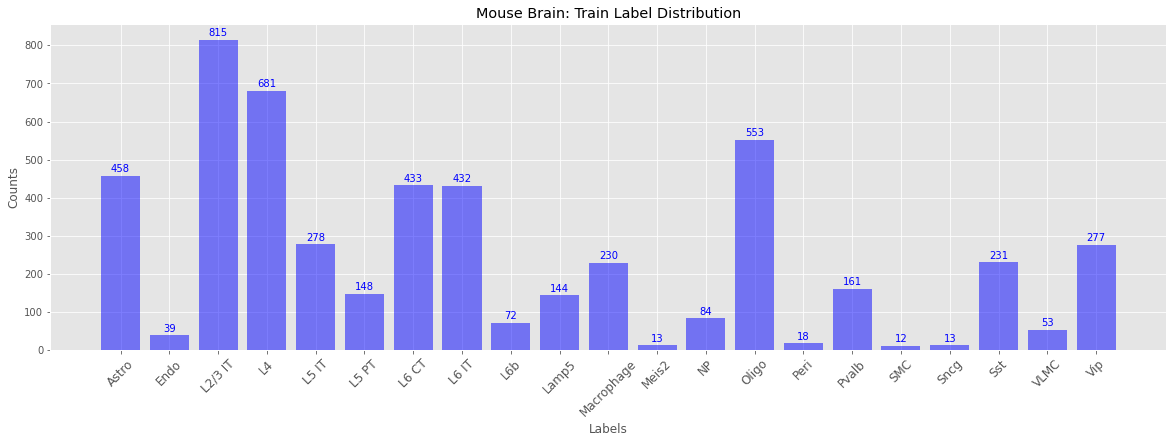

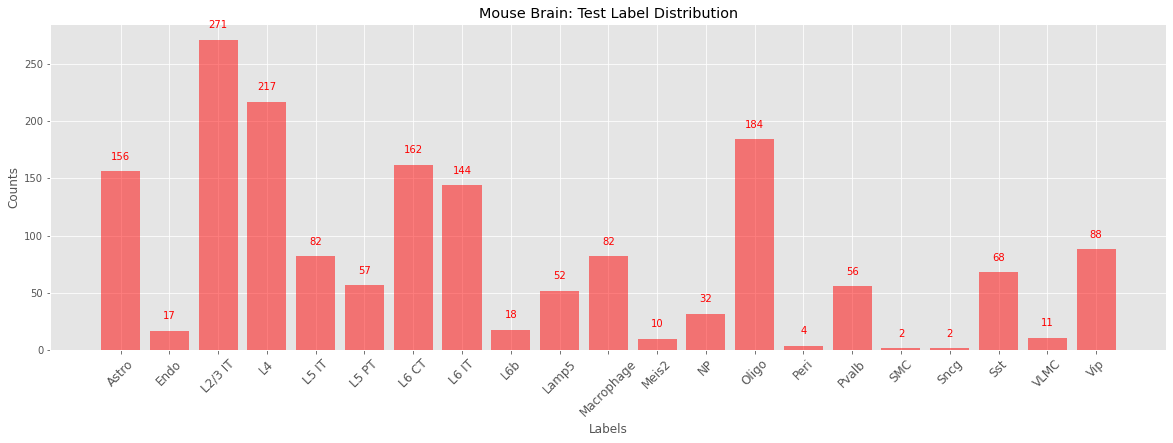

In [19]:
train_label_counts = np.unique(Y_train, return_counts=True)
test_label_counts = np.unique(Y_test, return_counts=True)

# Train Label Distribution
plt.figure(figsize=(20, 6))
plt.bar(train_label_counts[0], train_label_counts[1], color='blue', alpha=0.5)
for i in range(len(train_label_counts[0])):
    plt.text(train_label_counts[0][i], train_label_counts[1][i] + 10, str(train_label_counts[1][i]), ha='center', color='blue')
plt.xlabel('Labels')
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Counts')
plt.title('Mouse Brain: Train Label Distribution')
plt.show()

# Test Label Distribution
plt.figure(figsize=(20, 6))
plt.bar(test_label_counts[0], test_label_counts[1], color='red', alpha=0.5)
for i in range(len(test_label_counts[0])):
    plt.text(test_label_counts[0][i], test_label_counts[1][i] + 10, str(test_label_counts[1][i]), ha='center', color='red')
plt.xlabel('Labels')
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Counts')
plt.title('Mouse Brain: Test Label Distribution')
plt.show()

# Model Analysis

In [10]:
# load model
with open('models/MouseBrain_LogReg.pkl', 'rb') as f:
    best_model = pickle.load(f)

In [11]:
test_pred = best_model.predict(X_test)
train_pred = best_model.predict(X_train)
all_pred = best_model.predict(X)

## Accuracy

In [12]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# print("==== With Subtypes ====")
print(f"Train accuracy: {accuracy_score(Y_train, train_pred):.5f}")
print(f"Test accuracy: {accuracy_score(Y_test, test_pred):.5f}")
print("")
print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train, train_pred):.5f}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test, test_pred):.5f}")
print("")
# print("==== Main celltypes ====")
# print(f"Train accuracy: {accuracy_score(Y_train_main, train_main_pred):.5f}")
# print(f"Test accuracy: {accuracy_score(Y_test_main, test_main_pred):.5f}")
# print("")
# print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train_main, train_main_pred):.5f}")
# print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test_main, test_main_pred):.5f}")

Train accuracy: 1.00000
Test accuracy: 0.87172

Balanced Train Accuracy: 1.00000
Balanced Test Accuracy: 0.69802



## Classification Report

In [13]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, test_pred))

              precision    recall  f1-score   support

       Astro       0.97      0.99      0.98       156
        Endo       1.00      1.00      1.00        17
     L2/3 IT       0.86      0.98      0.91       271
          L4       0.87      0.90      0.88       217
       L5 IT       0.81      0.70      0.75        82
       L5 PT       0.92      0.98      0.95        57
       L6 CT       0.95      0.99      0.97       162
       L6 IT       0.84      0.72      0.77       144
         L6b       0.94      0.83      0.88        18
       Lamp5       0.94      0.58      0.71        52
  Macrophage       0.94      0.99      0.96        82
       Meis2       0.00      0.00      0.00        10
          NP       1.00      0.81      0.90        32
       Oligo       0.78      1.00      0.87       184
        Peri       0.43      0.75      0.55         4
       Pvalb       0.98      0.96      0.97        56
         SMC       0.00      0.00      0.00         2
        Sncg       0.00    

/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/gent/RHEL8/zen3x-ib/software/scikit-learn/1.0.1-foss-2021b/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [19]:
# print(classification_report(Y_test_main, test_main_pred))

## Confusion Matrix

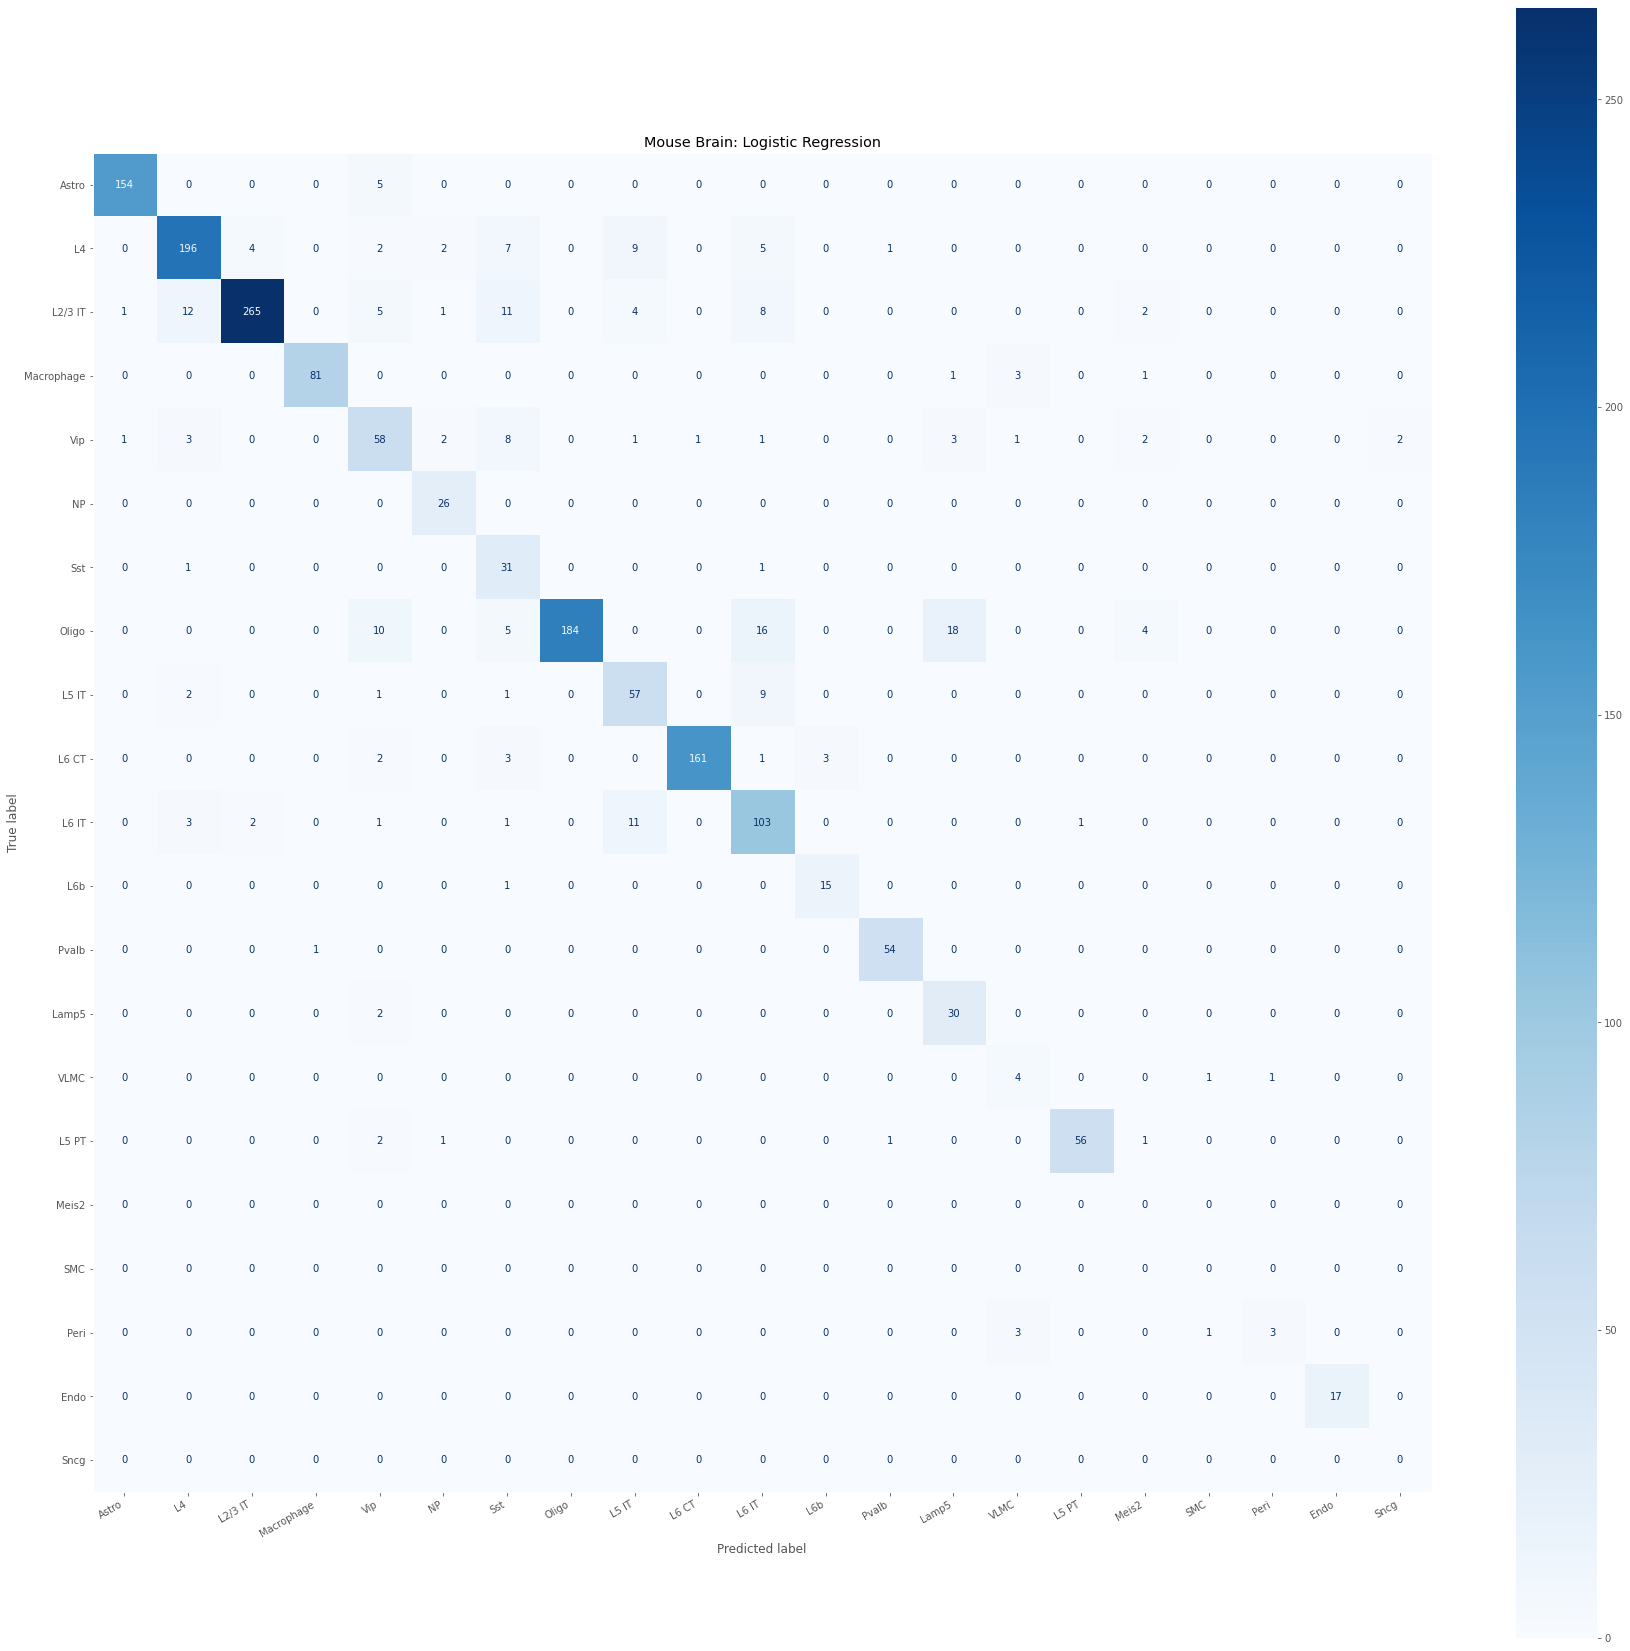

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# titles_options = [
#     ("Confusion matrix test predictions, without normalization", None, test_predictions, Y_test, cell_types_sorted),
#     ("Normalized confusion matrix test predictions", "true", test_predictions, Y_test, cell_types_sorted),
#     ("Confusion matrix test predictions main cell types, without normalization", None, test_main_pred, Y_test_main, main_cell_types_sorted),
#     ("Normalized confusion matrix test predictions main cell types", "true", test_main_pred, Y_test_main, main_cell_types_sorted),
# ]

plt.rcParams['figure.figsize'] = [30, 30]
# for title, normalize, pred, labels, celltypes in titles_options:

disp = ConfusionMatrixDisplay.from_predictions(
    test_pred,
    Y_test,
    cmap=plt.cm.Blues,
#     normalize=normalize,
    labels=Y.unique()
)
plt.xticks(rotation=30, ha='right')
disp.ax_.set_title('Mouse Brain: Logistic Regression')


plt.grid(False)
plt.show()